In [1]:
import torch

CONTENT_FILE = './input/boy/input_boy.wav'
STYLE_FILE = './input/girl/input_girl.wav'

learning_rate = 0.001

content_weight = 1.0
style_weight = 1.0

sampleRate = None # Use native sample rate
N_FFT = 512

print_period = 100
max_epochs = 20000

# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



# Reading

(56560,) (257, 442)
(68241,) (257, 534)
16000


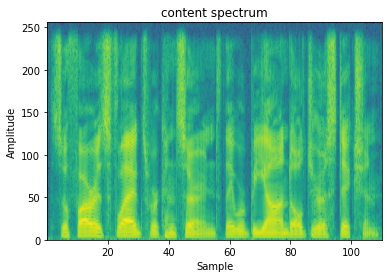

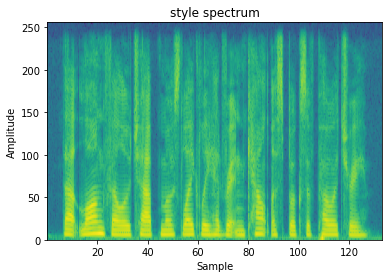

In [2]:
# from processing import *
from utils import *
import torch


x_content, sr = loadFile(CONTENT_FILE, sampleRate)
x_style, sr = loadFile(STYLE_FILE, sampleRate)

a_content = wav2spectrum(x_content, N_FFT)
a_style = wav2spectrum(x_style, N_FFT)

print(x_content.shape, a_content.shape)
print(x_style.shape, a_style.shape)
print(sr)

plot_spectrogram_with_raw_signal(x_content, N_FFT, 'content spectrum')
plot_spectrogram_with_raw_signal(x_style, N_FFT, 'style spectrum')


# Training

In [9]:
import torch.optim as optim
from models import *


model = RandomCNN()
model.eval()



a_C = torch.tensor(a_content[None, None, :, :], requires_grad = False, device = device).float()
a_S = torch.tensor(a_style[None, None, :, :], requires_grad = False, device = device).float()


# optimizer
a_G_var = torch.randn(a_C.shape, device = device) * 0.001
a_G_var.requires_grad = True

optimizer = optim.Adam(
    params = [a_G_var],
    lr = learning_rate,
)

model.to(device)

a_C = model(a_C)
a_S = model(a_S)


losses = []
style_losses = []
content_losses = []

for epoch in range(1, max_epochs + 1):

    optimizer.zero_grad()
    a_G = model(a_G_var)
    
    content_loss = content_weight * RandomCNN.compute_content_loss(a_C, a_G)
    style_loss = style_weight * RandomCNN.compute_layer_style_loss(a_S, a_G)

    loss = content_loss + style_loss
    loss.backward()
    optimizer.step()

    if epoch % print_period == 0:
        print('{}/{} content_loss: {:4f}, style_loss: {:4f}, total_loss: {:4f}'.format(
            epoch,
            max_epochs,
            content_loss,
            style_loss,
            loss
        ))

    losses.append(loss.detach().cpu())
    content_losses.append(content_loss.detach().cpu())
    style_losses.append(style_loss.detach().cpu())

gen_spectrum = a_G_var.cpu().data.numpy().squeeze()


100/20000 content_loss: 0.033503, style_loss: 717.713562, total_loss: 717.747070
200/20000 content_loss: 0.029846, style_loss: 610.654053, total_loss: 610.683899
300/20000 content_loss: 0.028402, style_loss: 491.674622, total_loss: 491.703033
400/20000 content_loss: 0.028123, style_loss: 382.542084, total_loss: 382.570221
500/20000 content_loss: 0.028406, style_loss: 293.391479, total_loss: 293.419891
600/20000 content_loss: 0.028903, style_loss: 223.680435, total_loss: 223.709335
700/20000 content_loss: 0.029474, style_loss: 170.029205, total_loss: 170.058685
800/20000 content_loss: 0.029952, style_loss: 129.517197, total_loss: 129.547150
900/20000 content_loss: 0.030411, style_loss: 99.508606, total_loss: 99.539017
1000/20000 content_loss: 0.030832, style_loss: 76.886665, total_loss: 76.917496
1100/20000 content_loss: 0.031240, style_loss: 60.486275, total_loss: 60.517513
1200/20000 content_loss: 0.031629, style_loss: 48.703812, total_loss: 48.735439
1300/20000 content_loss: 0.032017

# plot loss curve

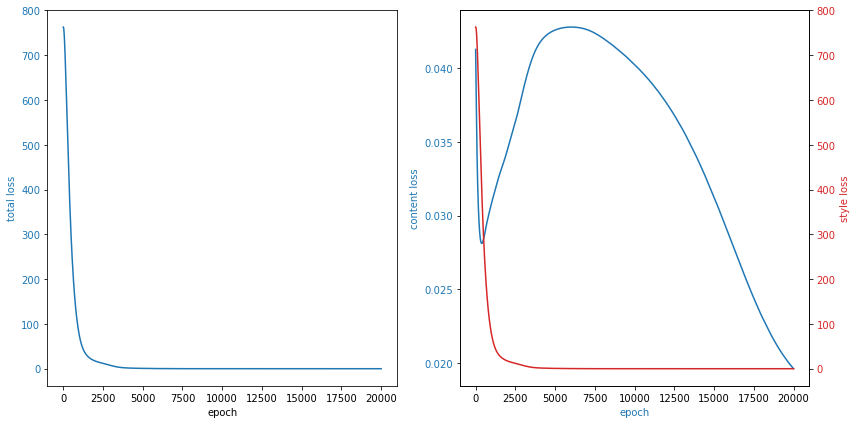

In [10]:
import utils

utils.plot_curve(content_losses, style_losses, losses, same_y_scale=False)

# Save file

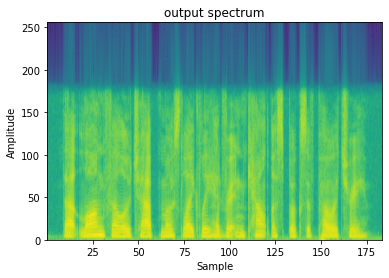

In [18]:
import os

filename = 'randomCNN.wav'

x = spectrum2wav(gen_spectrum, N_FFT)
writeFile(os.path.join('./output/', filename), x, sr)

plot_spectrogram_with_raw_signal(x_style, N_FFT, 'output spectrum')


# 